In [1]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
from scipy import stats
import os

In [2]:
r = np.array([      # five variables: 3 objectives, 2 constraints
    [1.0, 0.4, -0.5, 0.3, -0.2],
    [0.4, 1.0, 0.5, -0.3, -0.4],
    [-0.5, 0.5, 1.0, 0.2, -0.3],
    [0.3, -0.3, 0.2, 1.0, 0.5],
    [-0.2, -0.4, -0.3, 0.5, 1.0]
])

n = 100_000
shape, scale = [1.0, 2.0, 5.0, 1.5, 8.0], [2.0, 1.0, 0.5, 1.5, 0.3]

In [3]:
def make_pos_def(corr):
    eigvals, eigvecs = np.linalg.eigh(corr)
    eigvals[eigvals < 1e-8] = 1e-8  
    corr_pd = eigvecs @ np.diag(eigvals) @ eigvecs.T

    # normalize diagonal to 1
    d = np.sqrt(np.diag(corr_pd))
    corr_pd = corr_pd / d[:, None] / d[None, :]
    return corr_pd
r_psd = make_pos_def(r)

In [4]:
r_psd

array([[ 1.        ,  0.34315145, -0.42377034,  0.24529489, -0.16805087],
       [ 0.34315145,  1.        ,  0.43727715, -0.25553558, -0.41164733],
       [-0.42377034,  0.43727715,  1.        ,  0.14816138, -0.26380264],
       [ 0.24529489, -0.25553558,  0.14816138,  1.        ,  0.46603661],
       [-0.16805087, -0.41164733, -0.26380264,  0.46603661,  1.        ]])

In [5]:
mean = np.zeros(np.shape(r_psd)[0])
z = np.random.multivariate_normal(mean, r_psd, size=n)
u = stats.norm.cdf(z)

In [6]:
samples = np.zeros_like(u)
for i in range(u.shape[1]):
    samples[:, i] = stats.gamma.ppf(u[:, i], a=shape[i], scale=scale[i])

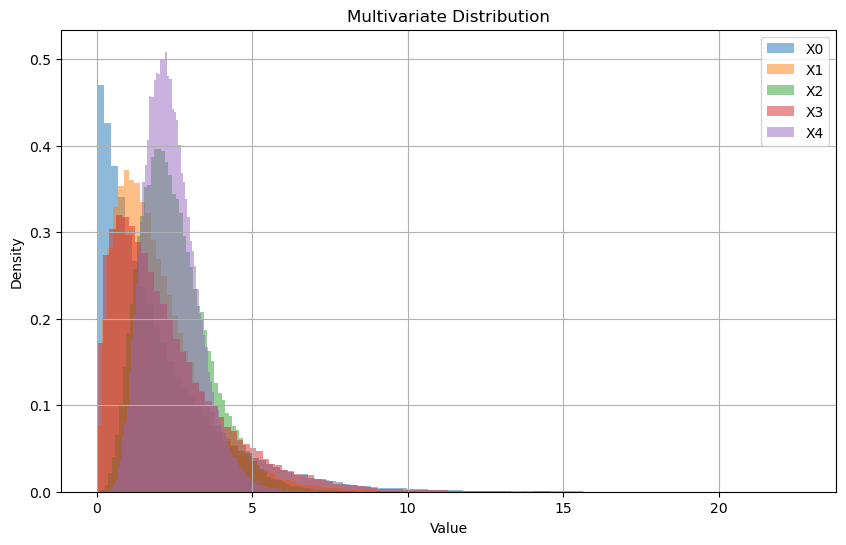

In [7]:
n_dims = samples.shape[1]

plt.figure(figsize=(10, 6))
for i in range(n_dims):
    plt.hist(samples[:, i], bins=100, density=True, alpha=0.5, label=f"X{i}")

plt.title("Multivariate Distribution")
plt.xlabel("Value")
plt.ylabel("Density")
# plt.xlim(0, 6)
plt.legend()
plt.grid(True)
plt.show()

In [8]:
expected_values = [a * b for a, b in zip(shape, scale)]

In [9]:
# generate data
def generate_knapsack_data(samples, shape, scale,         
                           n_items=10, max_trials=1000, exp_n_selected=5, trial_needed=100):

    # create column names (list)
    columns = (
        ['trial_number'] +
        [f'value1_item_{i+1}' for i in range(n_items)] +
        [f'value2_item_{i+1}' for i in range(n_items)] +
        [f'value3_item_{i+1}' for i in range(n_items)] +
        [f'weight1_item_{i+1}' for i in range(n_items)] +
        [f'weight2_item_{i+1}' for i in range(n_items)] +
        ['capacity1', 'capacity2']
    )

    # create df with 0's
    df = pd.DataFrame(0, index=range(max_trials), columns=columns)

    valid_trials = 0
    trial_i = 0
    cursor = 0
    
    while True:
        if valid_trials >= trial_needed:
            print(f"Done: built {valid_trials} trials (needed {trial_needed}).")
            break

        if trial_i >= max_trials:
            print(f"ERROR: exceeded max_trials ({max_trials}). Built {valid_trials} trials.")
            break

        if cursor >= samples.shape[0]:
            print(f"ERROR: ran out of samples at cursor={cursor} (N={samples.shape[0]}). "
                f"Built {valid_trials} trials; attempted {trial_i} trials.")
            break
    
        # obtain unique objective and constraint values for the trial
        values = np.empty((n_items, 3), dtype=int)
        weights = np.empty((n_items, 2), dtype=int)
        seen_obj = set()
        seen_con = set()
        item = 0
        while item < n_items:
            if cursor >= samples.shape[0]:
                print(f"ERROR: ran out of samples while filling trial {trial_i+1} "
                    f"(filled {item}/{n_items}).")
                break
            
            row = np.floor(samples[cursor, :]).astype(int)
            cursor += 1
            obj = tuple(row[:3])
            con = tuple(row[3:])

            if obj in seen_obj or con in seen_con:
                continue

            seen_obj.add(obj)
            seen_con.add(con)
            values[item, :]  = obj
            weights[item, :] = con
            item += 1

        # obtain capacities for the trial
        # expected number of items selected: exp_n_selected
        cp1 = stats.gamma.rvs(a=shape[3], scale=scale[3], size=1)[0] # can sample out of the loop
        cp2 = stats.gamma.rvs(a=shape[4], scale=scale[4], size=1)[0]
        capacity1 = np.floor(cp1 * exp_n_selected).astype(int) 
        capacity2 = np.floor(cp2 * exp_n_selected).astype(int) 

        # check if capacity is zero
        if capacity1 == 0 or capacity2 == 0:
            trial_i += 1
            continue
        
        # check if largest weight ratio is equal to orbelow 0.4
        ratios = np.vstack([
            weights[:, 0] / capacity1,
            weights[:, 1] / capacity2,
        ])
        largest_weight_ratio = ratios.max(axis=0) 
        if np.any(largest_weight_ratio > 0.4):
            trial_i += 1
            continue
            
        # store data into df
        df.loc[valid_trials, 'trial_number'] = valid_trials + 1
        for i in range(n_items):
            df.loc[valid_trials, f'value1_item_{i+1}'] = values[i, 0]
            df.loc[valid_trials, f'value2_item_{i+1}'] = values[i, 1]
            df.loc[valid_trials, f'value3_item_{i+1}'] = values[i, 2]
            df.loc[valid_trials, f'weight1_item_{i+1}'] = weights[i, 0]
            df.loc[valid_trials, f'weight2_item_{i+1}'] = weights[i, 1] 
        df.loc[valid_trials, 'capacity1'] = capacity1
        df.loc[valid_trials, 'capacity2'] = capacity2
    
        valid_trials += 1
        trial_i += 1

    df = df.iloc[:trial_needed].reset_index(drop=True)  


    output_dir = "./data"
    os.makedirs(output_dir, exist_ok=True)
    output_path = os.path.join(output_dir, f'test_data_n{n_items}_exp{exp_n_selected}_clean.csv')
    if os.path.exists(output_path):
        print(f"File {output_path} already exists")
    else:
        df.to_csv(output_path, index=False)
        print(f"File {output_path} created successfully")

In [10]:
generate_knapsack_data(samples, shape, scale,
                       n_items=20, max_trials=100, exp_n_selected=5, trial_needed=1)

Done: built 1 trials (needed 1).
File ./data/test_data_n20_exp5_clean.csv already exists


In [11]:
np.corrcoef(samples.T)

array([[ 1.        ,  0.30781652, -0.36114364,  0.2196891 , -0.14342655],
       [ 0.30781652,  1.        ,  0.41557776, -0.21624508, -0.3717236 ],
       [-0.36114364,  0.41557776,  1.        ,  0.13700868, -0.25276141],
       [ 0.2196891 , -0.21624508,  0.13700868,  1.        ,  0.44152598],
       [-0.14342655, -0.3717236 , -0.25276141,  0.44152598,  1.        ]])

In [12]:
n_items = 20
df = pd.read_csv('./data/test_data_n20_exp5_clean.csv')
df.head()

,trial_number,value1_item_1,value1_item_2,value1_item_3,value1_item_4,value1_item_5,value1_item_6,value1_item_7,value1_item_8,value1_item_9,...,weight2_item_13,weight2_item_14,weight2_item_15,weight2_item_16,weight2_item_17,weight2_item_18,weight2_item_19,weight2_item_20,capacity1,capacity2
0,1,0,1,0,3,1,4,2,0,2,...,2,2,3,3,2,0,4,0,21,14


In [13]:
# reshape data for visualization
items_df_visual = pd.DataFrame()

for trial in range(len(df)):
    trial_data = []
    for item in range(1, n_items+1): 
        row = {
            'Card number': item,
            'Science': df[f'value1_item_{item}'][trial],
            'Culture': df[f'value2_item_{item}'][trial],
            'Govern': df[f'value3_item_{item}'][trial],
            'Money': df[f'weight1_item_{item}'][trial],
            'Space': df[f'weight2_item_{item}'][trial],
            'capacity1': df['capacity1'][trial],
            'capacity2': df['capacity2'][trial],
        }
        trial_data.append(row)
    items_df_visual = pd.concat([items_df_visual, pd.DataFrame(trial_data)], ignore_index=True) ## create a new sequential index

items_df_visual

,Card number,Science,Culture,Govern,Money,Space,capacity1,capacity2
0,1,0,1,2,1,1,21,14
1,2,1,3,3,2,2,21,14
2,3,0,0,2,2,3,21,14
3,4,3,1,2,4,1,21,14
4,5,1,1,4,8,2,21,14
5,6,4,2,2,2,1,21,14
6,7,2,1,1,0,1,21,14
7,8,0,2,3,0,2,21,14
8,9,2,2,1,1,3,21,14
9,10,2,9,6,0,0,21,14


In [14]:
items_df_visual.iloc[:, 1:6].corr(method='pearson')

,Science,Culture,Govern,Money,Space
Science,1.000000,0.064254,-0.366624,-0.172603,-0.421464
Culture,0.064254,1.000000,0.676467,-0.385535,-0.454463
Govern,-0.366624,0.676467,1.000000,0.174405,-0.330160
Money,-0.172603,-0.385535,0.174405,1.000000,0.388011
Space,-0.421464,-0.454463,-0.330160,0.388011,1.000000


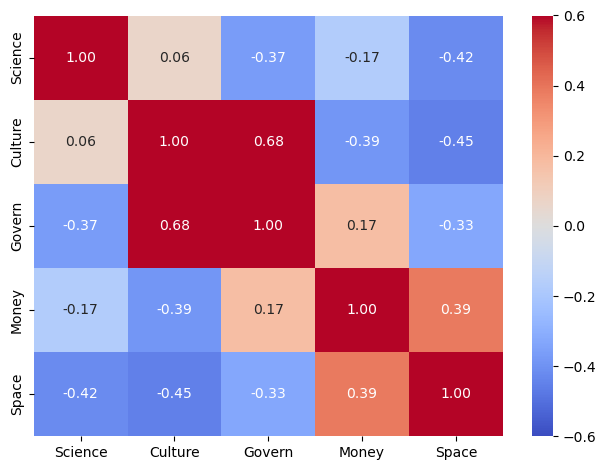

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.heatmap(items_df_visual.iloc[:, 1:6].corr(method='pearson'),
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  
# plt.savefig("corr_matrix_50cards.png", dpi=300, bbox_inches='tight')
plt.show()

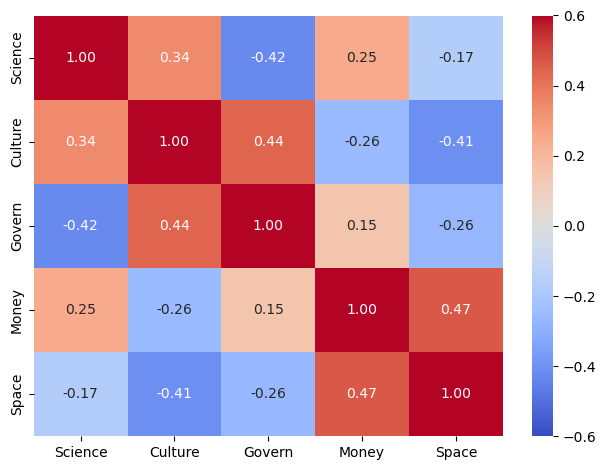

In [16]:
labels = ["Science", "Culture", "Govern", "Money", "Space"]
sns.heatmap(r_psd, xticklabels=labels, yticklabels=labels,
            annot=True, fmt=".2f", cmap='coolwarm',vmin=-0.6,vmax =0.6)
plt.tight_layout()  # ensures labels aren’t cut off
# plt.savefig("corr_matrix_orginal.png", dpi=300, bbox_inches='tight')
plt.show()